In [1]:
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader, Dataset, random_split

In [2]:
import random

seed = 1004
random.seed(seed)
th.manual_seed(seed)
if th.cuda.is_available():
    th.cuda.manual_seed(seed)

In [3]:
# load dataset

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_dataset, val_dataset = random_split(train_dataset, [54000, 6000])

In [5]:
print(f'Train size: {len(train_dataset)}')
print(f'Validation size: {len(val_dataset)}')
print(f'Test size: {len(test_dataset)}')

Train size: 54000
Validation size: 6000
Test size: 10000


In [6]:
trian_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True, drop_last=True)

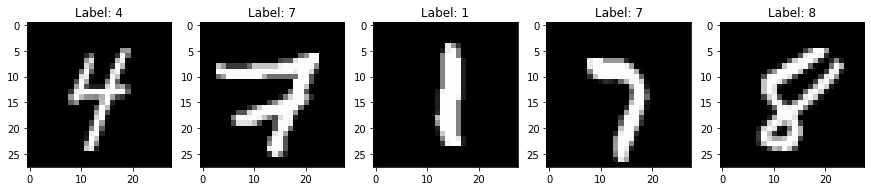

In [7]:
num_sample = 5
random_idx = np.random.randint(0, len(train_dataset), num_sample)

plt.figure(figsize=(15, 3))
for i, idx in enumerate(random_idx):
    img, label = train_dataset[idx]
    plt.subplot(1, num_sample, i+1)
    plt.title(f'Label: {label}')
    plt.imshow(img.squeeze(), cmap='gray')

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 10)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        out = F.log_softmax(x, dim=1)
        return out

In [24]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    return np.mean(train_losses)

def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0

    with th.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset)}%)\n')

    return test_loss

In [25]:
def run(model,
        train_loader,
        val_loader,
        test_loader,
        optimizer,
        num_epoch):
    
    device = th.device('cuda' if th.cuda.is_available() else 'cpu')
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.7)
    model = model.to(device)
    train_losses = []
    val_losses = []
    for epoch in range(1, num_epoch + 1):
        train_loss = train(model, train_loader, optimizer, epoch, device)
        val_loss = test(model, val_loader, device)
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    th.save(model.state_dict(), 'mnist.pt')

    test_loss = test(model, test_loader, device)

    return train_losses, val_losses, test_loss


In [26]:
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
history = run(model, trian_loader, val_loader, test_loader, optimizer, 14)

Train Epoch: 1 [0/54000 (0%)]	Loss: 2.290116
Train Epoch: 1 [6400/54000 (12%)]	Loss: 0.340545
Train Epoch: 1 [12800/54000 (24%)]	Loss: 0.124396
Train Epoch: 1 [19200/54000 (36%)]	Loss: 0.148082
Train Epoch: 1 [25600/54000 (47%)]	Loss: 0.092516
Train Epoch: 1 [32000/54000 (59%)]	Loss: 0.089472
Train Epoch: 1 [38400/54000 (71%)]	Loss: 0.175047
Train Epoch: 1 [44800/54000 (83%)]	Loss: 0.259994
Train Epoch: 1 [51200/54000 (95%)]	Loss: 0.357045

Test set: Average loss: 0.1036, Accuracy: 5763/6000 (96.05%)

Train Epoch: 2 [0/54000 (0%)]	Loss: 0.138427
Train Epoch: 2 [6400/54000 (12%)]	Loss: 0.047439
Train Epoch: 2 [12800/54000 (24%)]	Loss: 0.097280
Train Epoch: 2 [19200/54000 (36%)]	Loss: 0.072376
Train Epoch: 2 [25600/54000 (47%)]	Loss: 0.041092
Train Epoch: 2 [32000/54000 (59%)]	Loss: 0.083693
Train Epoch: 2 [38400/54000 (71%)]	Loss: 0.236624
Train Epoch: 2 [44800/54000 (83%)]	Loss: 0.106424
Train Epoch: 2 [51200/54000 (95%)]	Loss: 0.151480

Test set: Average loss: 0.0736, Accuracy: 5817/6

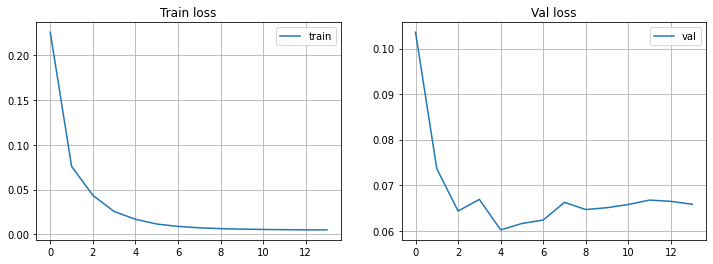

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(history[0], label='train')
ax[1].plot(history[1], label='val')
ax[0].set_title('Train loss')
ax[1].set_title('Val loss')
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)

In [45]:
test(model, test_loader, th.device('cuda'))


Test set: Average loss: 0.0681, Accuracy: 9808/10000 (98.08%)



0.06812374950675294

In [48]:
pred_ys = model(th.stack([test_dataset[i][0] for i in range(len(test_dataset))]).to(th.device('cuda'))).argmax(dim=1).cpu().numpy()

In [49]:
pred_ys.shape

(10000,)

In [54]:
(pred_ys == np.array([test_dataset[i][1] for i in range(len(test_dataset))])).sum() / len(test_dataset)

0.9824

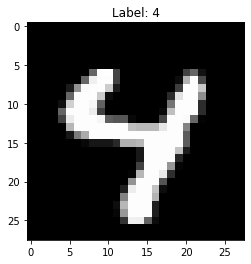

In [57]:
plt.imshow(test_dataset[1010][0].squeeze(), cmap='gray')
plt.title(f'Label: {pred_ys[1010]}')
plt.show()